In [29]:
# Import necessary libraries
import uproot
import awkward as ak
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
import dgl
import torch
import os
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import json
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.pyplot as plt
from dgl import to_networkx

In [2]:
# Ensure directories for saving outputs
os.makedirs("../graphs/", exist_ok=True)

In [3]:
# Step 1: Load .root file

# Open the .root file
file_path = "../data/JetClass_example_100k.root"
file = uproot.open(file_path)

# List all keys
keys = file.keys()

print("Keys in the ROOT file:")
for key in keys:
    print(key)


Keys in the ROOT file:
tree;5


In [4]:
tree_name = "tree"  
tree = file[tree_name]

# List the branches in the tree
print("Branches in the tree:")
print(tree.keys())


Branches in the tree:
['part_px', 'part_py', 'part_pz', 'part_energy', 'part_deta', 'part_dphi', 'part_d0val', 'part_d0err', 'part_dzval', 'part_dzerr', 'part_charge', 'part_isChargedHadron', 'part_isNeutralHadron', 'part_isPhoton', 'part_isElectron', 'part_isMuon', 'label_QCD', 'label_Hbb', 'label_Hcc', 'label_Hgg', 'label_H4q', 'label_Hqql', 'label_Zqq', 'label_Wqq', 'label_Tbqq', 'label_Tbl', 'jet_pt', 'jet_eta', 'jet_phi', 'jet_energy', 'jet_nparticles', 'jet_sdmass', 'jet_tau1', 'jet_tau2', 'jet_tau3', 'jet_tau4', 'aux_genpart_eta', 'aux_genpart_phi', 'aux_genpart_pid', 'aux_genpart_pt', 'aux_truth_match']


In [5]:
data = uproot.open(file_path)[tree_name].arrays(library="ak")

In [6]:
# # Step 2: Extract features
# features = ak.to_dataframe(data[
#     [
#         "part_px",
#         "part_py",
#         "part_pz",
#         "part_energy",
#         "part_deta",
#         "part_dphi",
#         "part_charge",
#         "part_isChargedHadron",
#         "part_isNeutralHadron",
#         "part_isPhoton",
#         "part_isElectron",
#         "part_isMuon",
#     ]
# ])
# print(features.head())

In [7]:
# Step 2: Extract particle-level features
particle_features = ak.to_dataframe(data[
    [
        "part_px",
        "part_py",
        "part_pz",
        "part_energy",
        "part_deta",
        "part_dphi",
        "part_d0val",
        "part_d0err",
        "part_dzval",
        "part_dzerr",
        "part_charge",
        "part_isChargedHadron",
        "part_isNeutralHadron",
        "part_isPhoton",
        "part_isElectron",
        "part_isMuon"
    ]
])

In [8]:
# Step 3: Extract jet-level features
jet_features = ak.to_dataframe(data[
    [
        "jet_pt",
        "jet_eta",
        "jet_phi",
        "jet_energy",
        "jet_nparticles",
        "jet_sdmass",
        "jet_tau1",
        "jet_tau2",
        "jet_tau3",
        "jet_tau4"
    ]
])

In [9]:
print("Particle Features Sample:")
print(particle_features.head())

print("Jet Features Sample:")
print(jet_features.head())

Particle Features Sample:
                   part_px    part_py    part_pz  part_energy  part_deta  \
entry subentry                                                             
0     0        -124.576714  64.301697 -36.050991   144.754074  -0.072420   
      1         -91.080833  27.989893 -39.437183   103.123436   0.076079   
      2         -83.185188  28.240173 -37.305996    95.441185   0.086017   
      3         -68.857361  21.931194 -30.972980    78.623405   0.089636   
      4         -66.776909  19.477356 -23.233171    73.336914   0.001267   

                part_dphi  part_d0val  part_d0err  part_dzval  part_dzerr  \
entry subentry                                                              
0     0         -0.085811    0.077095       0.011    0.030595      0.0318   
      1          0.092534    0.000000       0.000    0.000000      0.0000   
      2          0.063405    0.000000       0.000    0.000000      0.0000   
      3          0.082339    0.000000       0.000    0.0

In [11]:
# Extract the label columns
label_columns = [
    "label_QCD",
    "label_Hbb",
    "label_Hcc",
    "label_Hgg",
    "label_H4q",
    "label_Hqql",
    "label_Zqq",
    "label_Wqq",
    "label_Tbqq",
    "label_Tbl"
]

In [15]:
# Convert the label columns into a single integer label for each jet
labels = []
for _, row in ak.to_dataframe(data[label_columns]).iterrows():
    # Find the index of the column with value 1
    label = row.idxmax()  # idxmax gives the column name of the maximum value (1 in this case)
    labels.append(label_columns.index(label))  # Convert column name to its index
print(labels)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [16]:
# Step 4: Create kNN Graphs
def create_graph(particle_features, jet_features, k=3):
    # kNN graph construction
    nbrs = NearestNeighbors(n_neighbors=k).fit(particle_features)
    indices = nbrs.kneighbors(particle_features, return_distance=False)

    # Initialize the graph
    num_nodes = len(particle_features)
    edges_src, edges_dst = [], []

    for i, neighbors in enumerate(indices):
        for neighbor in neighbors:
            edges_src.append(i)
            edges_dst.append(neighbor)

    # Create the DGLGraph using edge lists
    g = dgl.graph((edges_src, edges_dst), num_nodes=num_nodes)

    # Add node features (particle-level features)
    g.ndata["feat"] = torch.tensor(particle_features, dtype=torch.float32)

    # Add graph-level features (jet-level features)
    g.graph_attr = {"jet_features": torch.tensor(jet_features, dtype=torch.float32)}

    return g

In [17]:
# Step 5: Construct graphs for each jet using parallel processing
def create_single_graph(particle_features, jet_features_row):
    particle_features_array = particle_features.values
    jet_features_array = jet_features_row[1].values  # jet_features_row[1] is a pandas Series
    return create_graph(particle_features_array, jet_features_array)

graphs = Parallel(n_jobs=-1)(
    delayed(create_single_graph)(jet, jet_feature_row)
    for (idx, jet), jet_feature_row in zip(particle_features.groupby(level=0), jet_features.iterrows())
)

/media/drive1/jettag/env_jet/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [12]:
# # Step 5: Construct graphs for each jet
# graphs = []
# for (idx, jet), jet_feature_row in zip(particle_features.groupby(level=0), jet_features.iterrows()):
#     # Extract particle features for the jet
#     particle_features_array = jet.values
    
#     # Extract corresponding jet-level features
#     jet_features_array = jet_feature_row[1].values  # jet_feature_row[1] is a pandas Series
    
#     # Create a graph for the jet
#     graphs.append(create_graph(particle_features_array, jet_features_array))

In [20]:
print(f"Type of graphs: {type(graphs)}, Number of graphs: {len(graphs) if hasattr(graphs, '__len__') else 'Not Applicable'}")


Type of graphs: <class 'list'>, Number of graphs: 100000


In [18]:
# Step 6: Save graphs
if not os.path.exists("../graphs/"):
    os.makedirs("../graphs/")
torch.save(graphs, "../graphs/graphs.pt")
print("Graphs saved successfully!")

Graphs saved successfully!


In [21]:
graphs = torch.load("../graphs/graphs.pt")
print(f"Type of graphs: {type(graphs)}, Number of graphs: {len(graphs) if hasattr(graphs, '__len__') else 'Not Applicable'}")


/tmp/ipykernel_2539561/609668982.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graphs = torch.load("../graphs/graphs.pt")


Type of graphs: <class 'list'>, Number of graphs: 100000


In [22]:
print(graphs[0])  # View the first graph

Graph(num_nodes=38, num_edges=114,
      ndata_schemes={'feat': Scheme(shape=(16,), dtype=torch.float32)}
      edata_schemes={})


In [23]:
for i in range(5):  # Change the range to view more graphs
    print(f"Graph {i}: {graphs[i]}")

Graph 0: Graph(num_nodes=38, num_edges=114,
      ndata_schemes={'feat': Scheme(shape=(16,), dtype=torch.float32)}
      edata_schemes={})
Graph 1: Graph(num_nodes=30, num_edges=90,
      ndata_schemes={'feat': Scheme(shape=(16,), dtype=torch.float32)}
      edata_schemes={})
Graph 2: Graph(num_nodes=39, num_edges=117,
      ndata_schemes={'feat': Scheme(shape=(16,), dtype=torch.float32)}
      edata_schemes={})
Graph 3: Graph(num_nodes=32, num_edges=96,
      ndata_schemes={'feat': Scheme(shape=(16,), dtype=torch.float32)}
      edata_schemes={})
Graph 4: Graph(num_nodes=45, num_edges=135,
      ndata_schemes={'feat': Scheme(shape=(16,), dtype=torch.float32)}
      edata_schemes={})


In [24]:
subset_graphs = graphs[:10]  # Extract the first 10 graphs
torch.save(subset_graphs, "../graphs/subset_graphs.pt")
print("Subset of graphs saved!")


Subset of graphs saved!


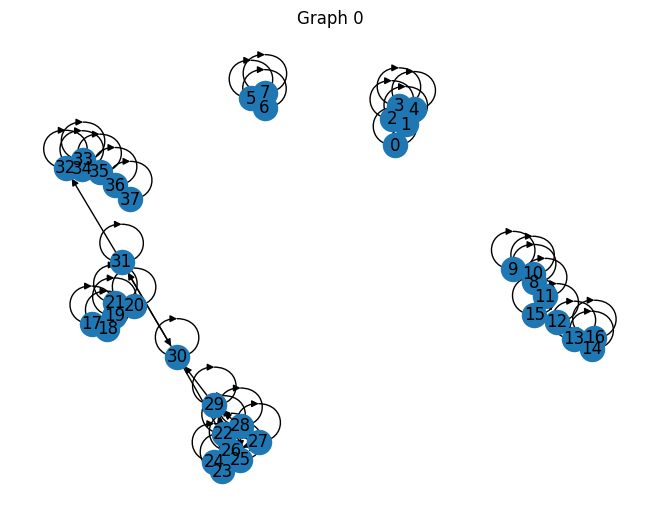

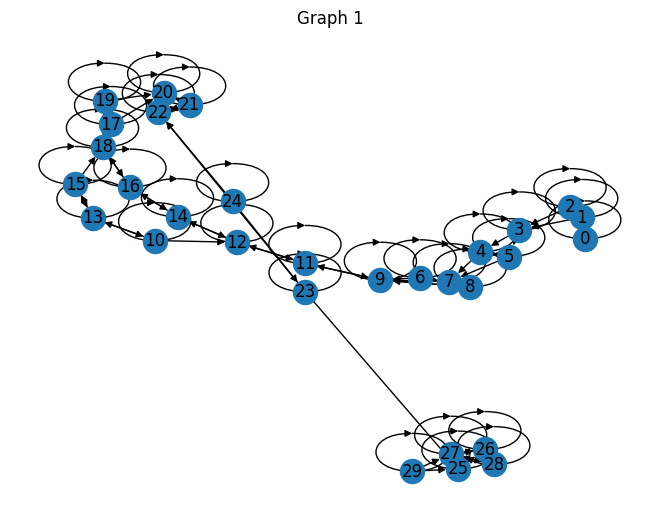

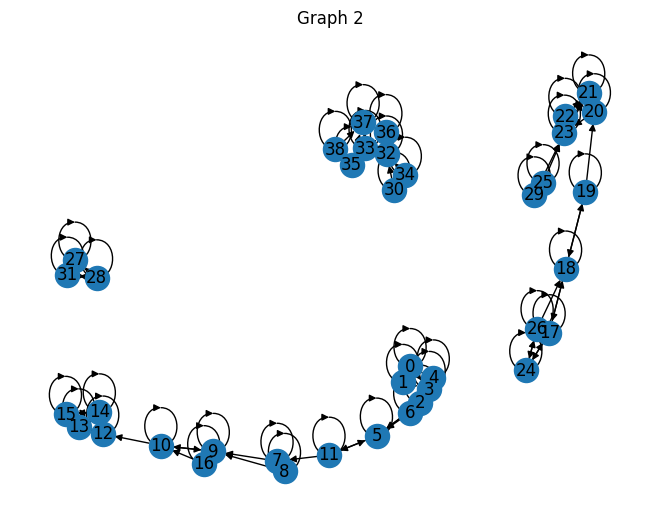

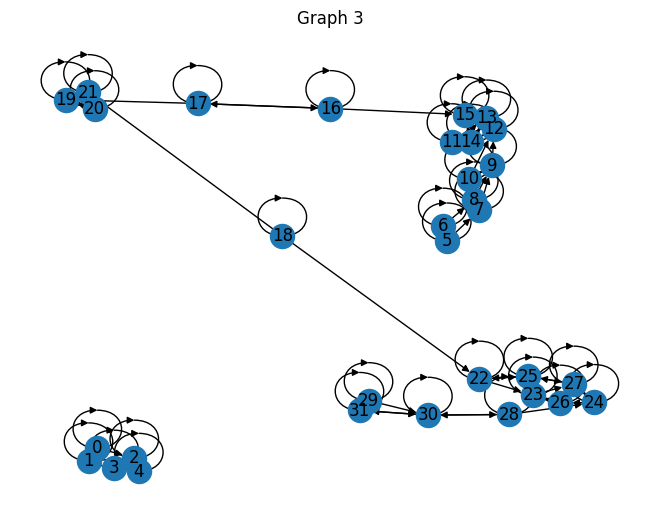

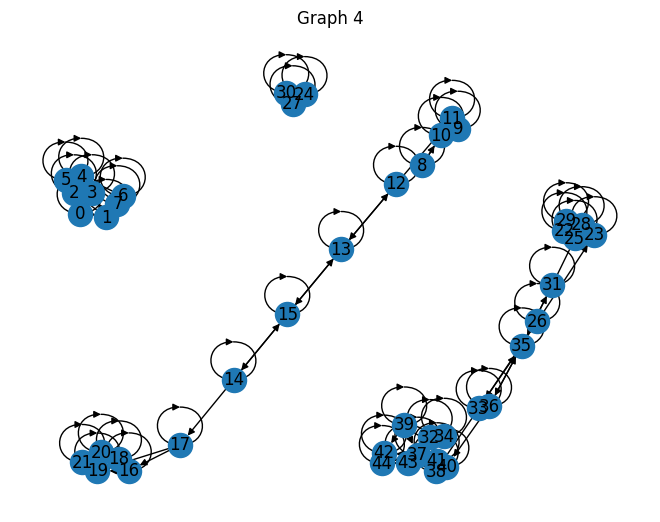

In [25]:
for i in range(5):  # Adjust range as needed
    G_dgl = graphs[i]  # DGL graph
    G_nx = G_dgl.to_networkx()  # Convert to NetworkX graph
    nx.draw(G_nx, with_labels=True)
    plt.title(f"Graph {i}")
    plt.show()

Inspecting graphs...
Graph 0:
  Nodes: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37])
  Edges: (tensor([ 0,  0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  5,
         6,  6,  6,  7,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10, 10, 11, 11, 11,
        12, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 15, 16, 16, 16, 17, 17, 17,
        18, 18, 18, 19, 19, 19, 20, 20, 20, 21, 21, 21, 22, 22, 22, 23, 23, 23,
        24, 24, 24, 25, 25, 25, 26, 26, 26, 27, 27, 27, 28, 28, 28, 29, 29, 29,
        30, 30, 30, 31, 31, 31, 32, 32, 32, 33, 33, 33, 34, 34, 34, 35, 35, 35,
        36, 36, 36, 37, 37, 37]), tensor([ 0,  1,  2,  1,  2,  3,  2,  1,  3,  3,  4,  2,  4,  3,  2,  5,  6,  7,
         6,  5,  7,  7,  6,  5,  8, 10, 11,  9, 10,  8, 10, 11,  8, 11, 10, 12,
        12, 15, 16, 13, 14, 16, 14, 16, 13, 15, 12, 16, 16, 14, 13, 17, 19, 18,
        18, 17, 19, 

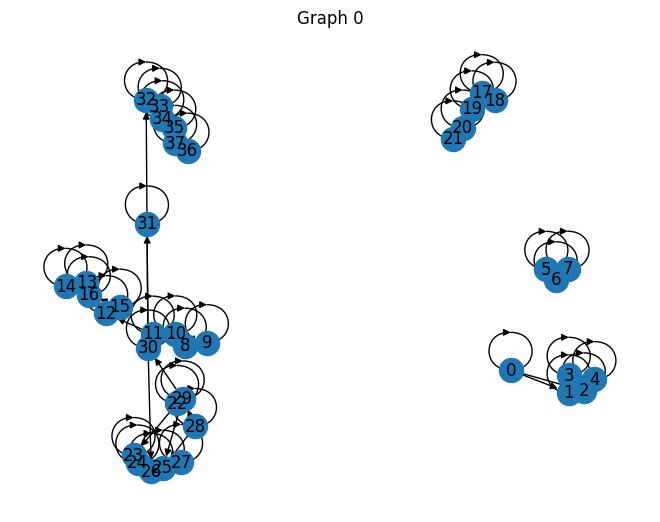

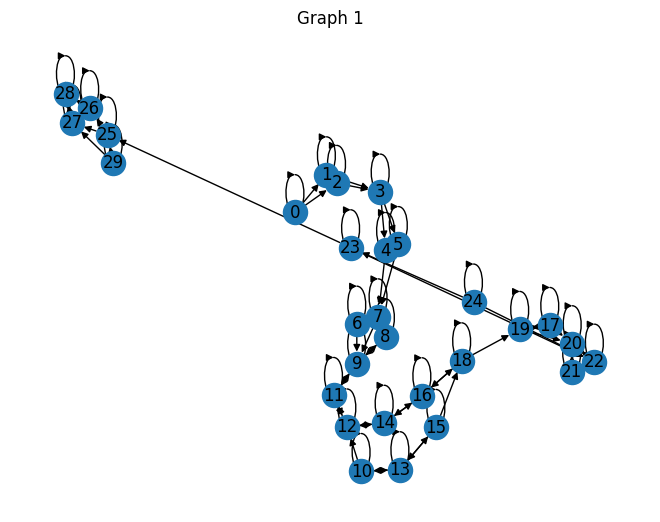

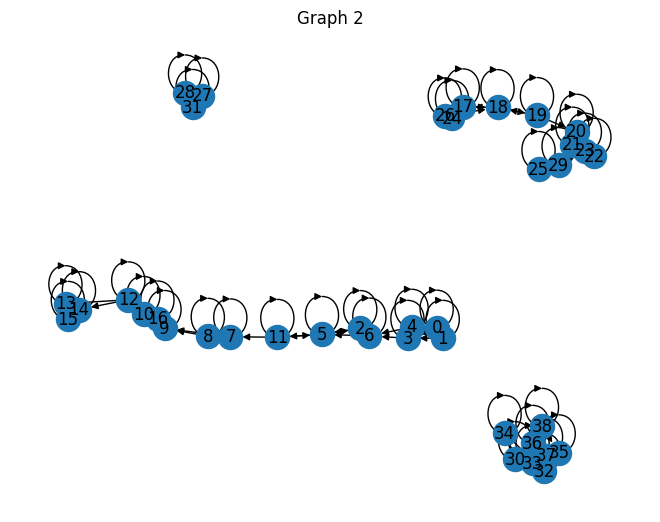

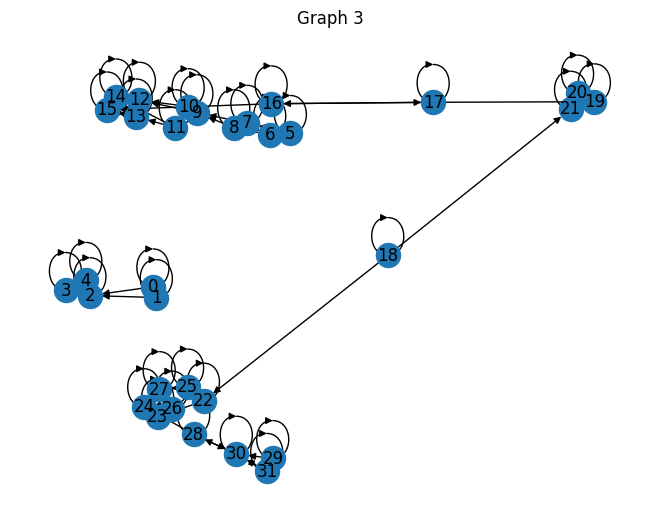

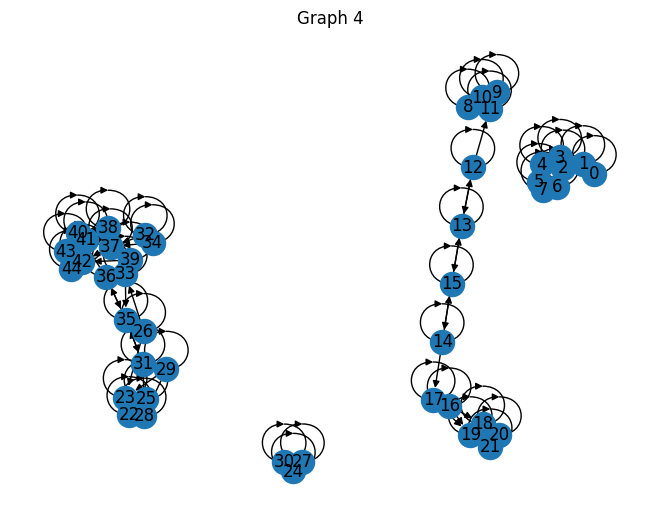


Visualizing graphs by edge types (if applicable)...
Graph 0 edge types: ['_E']
Visualizing edge type: _E


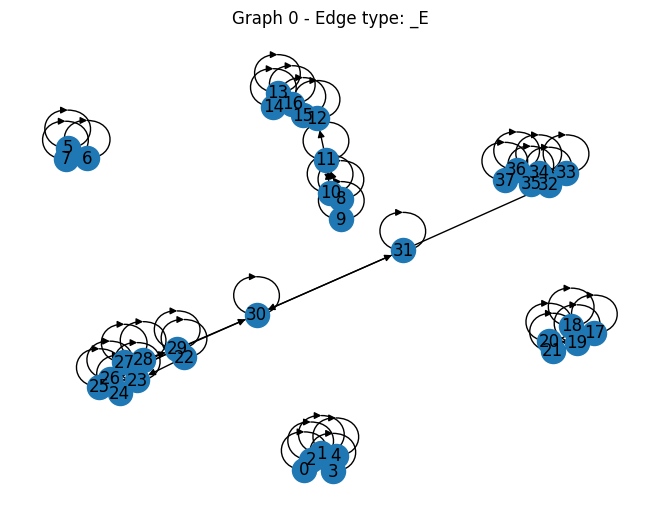

Graph 1 edge types: ['_E']
Visualizing edge type: _E


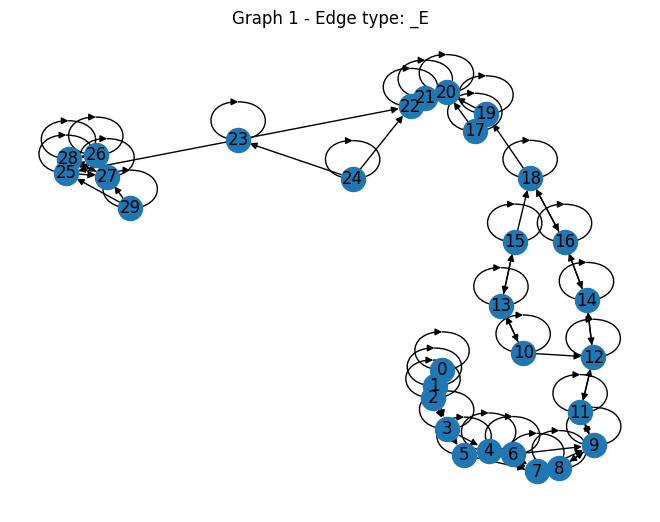

Graph 2 edge types: ['_E']
Visualizing edge type: _E


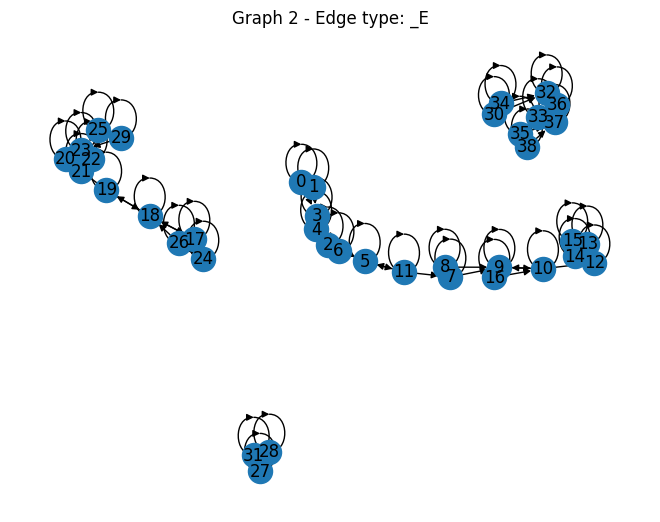

Graph 3 edge types: ['_E']
Visualizing edge type: _E


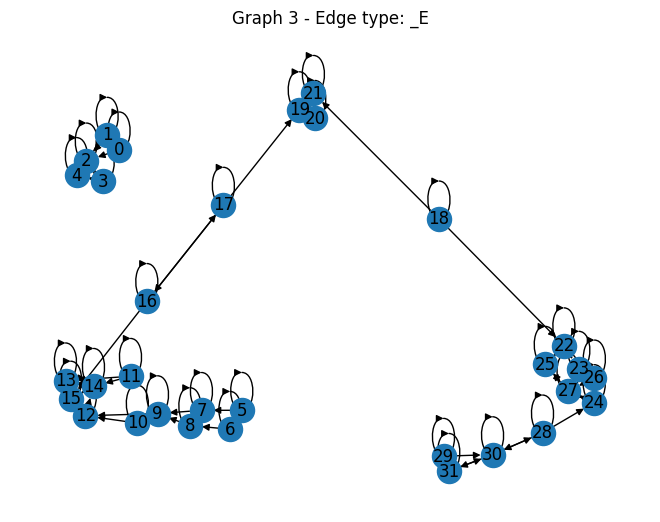

Graph 4 edge types: ['_E']
Visualizing edge type: _E


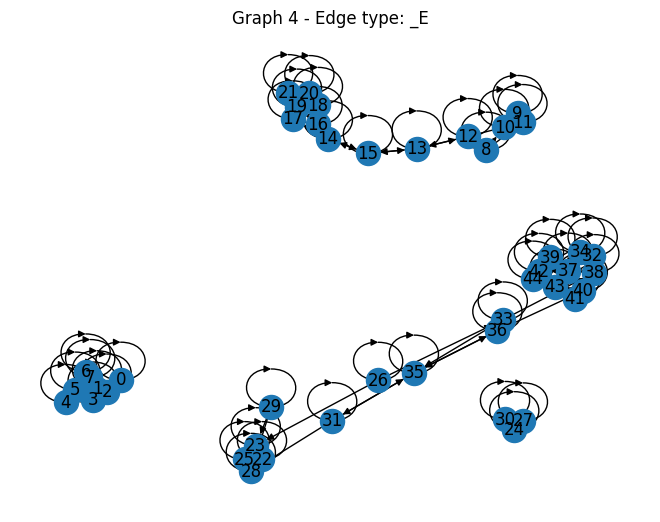

In [26]:
# Function to inspect the graphs
def inspect_graphs(graphs, num_graphs=5):
    for i in range(min(num_graphs, len(graphs))):
        graph = graphs[i]
        print(f"Graph {i}:")
        print(f"  Nodes: {graph.nodes()}")
        print(f"  Edges: {graph.edges()}")
        print(f"  Edge types: {graph.etypes if hasattr(graph, 'etypes') else 'N/A'}")
        print()

# Function to visualize graphs
def visualize_graphs(graphs, num_graphs=5):
    for i in range(min(num_graphs, len(graphs))):
        try:
            G_dgl = graphs[i]
            if isinstance(G_dgl, dgl.DGLGraph):  # Check if it's a DGL graph
                # Convert to NetworkX for visualization
                G_nx = G_dgl.to_networkx()
                nx.draw(G_nx, with_labels=True)
                plt.title(f"Graph {i}")
                plt.show()
            else:
                print(f"Graph {i} is not a DGL graph, skipping visualization.")
        except Exception as e:
            print(f"Error visualizing graph {i}: {e}")

# Function to handle edge types (if needed)
def visualize_edge_types(graphs, num_graphs=5):
    for i in range(min(num_graphs, len(graphs))):
        try:
            G_dgl = graphs[i]
            if hasattr(G_dgl, 'etypes'):  # Check if the graph has edge types
                print(f"Graph {i} edge types: {G_dgl.etypes}")
                for edge_type in G_dgl.etypes:
                    print(f"Visualizing edge type: {edge_type}")
                    subgraph = G_dgl.edge_type_subgraph([edge_type])
                    G_nx = subgraph.to_networkx()
                    nx.draw(G_nx, with_labels=True)
                    plt.title(f"Graph {i} - Edge type: {edge_type}")
                    plt.show()
            else:
                print(f"Graph {i} has no edge types.")
        except Exception as e:
            print(f"Error handling edge types for graph {i}: {e}")

# Main function to combine all steps
def process_and_visualize_graphs(graphs, num_graphs=5):
    print("Inspecting graphs...")
    inspect_graphs(graphs, num_graphs)
    
    print("\nVisualizing graphs...")
    visualize_graphs(graphs, num_graphs)
    
    print("\nVisualizing graphs by edge types (if applicable)...")
    visualize_edge_types(graphs, num_graphs)

# Process and visualize graphs
process_and_visualize_graphs(graphs, num_graphs=5)


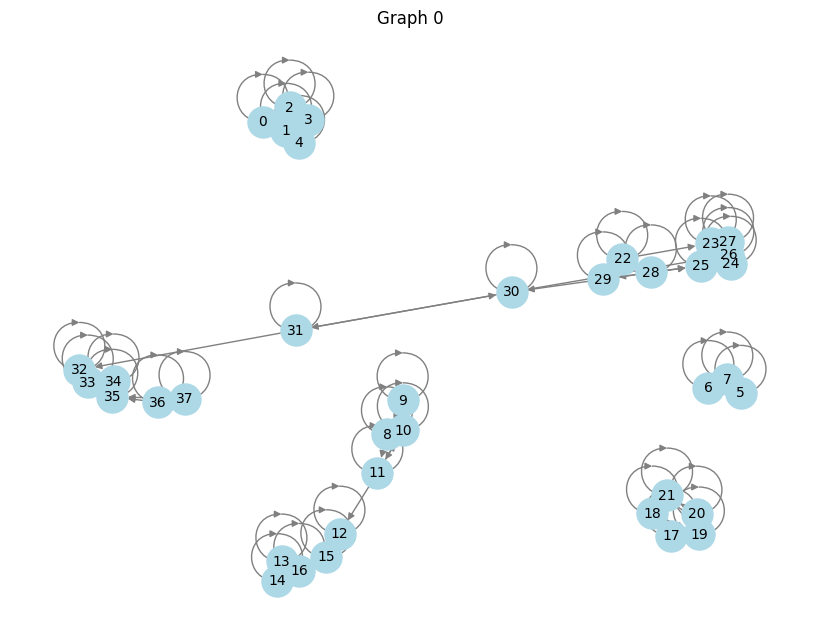

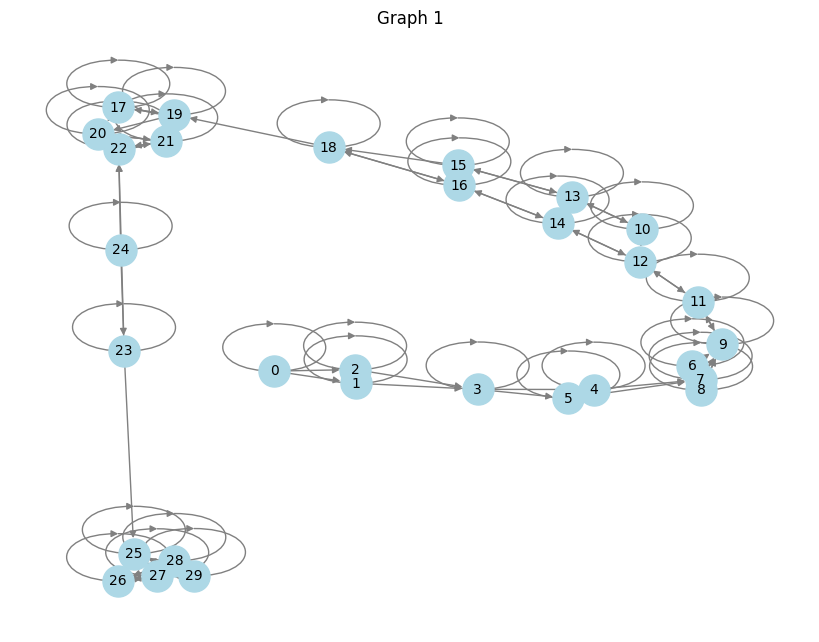

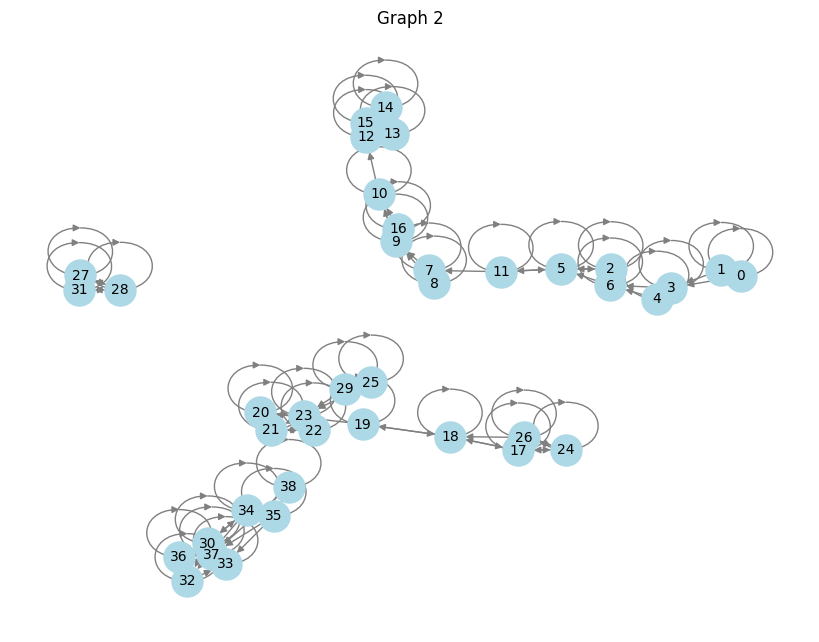

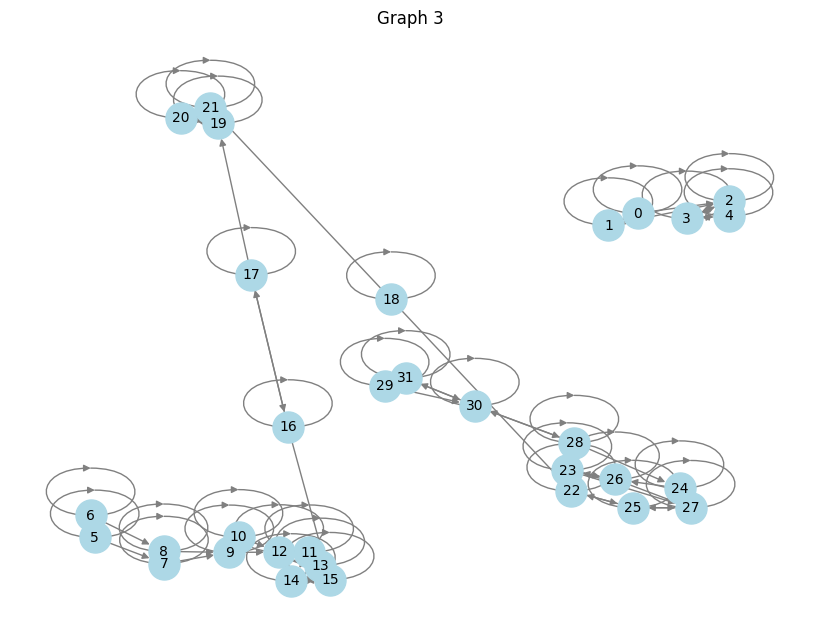

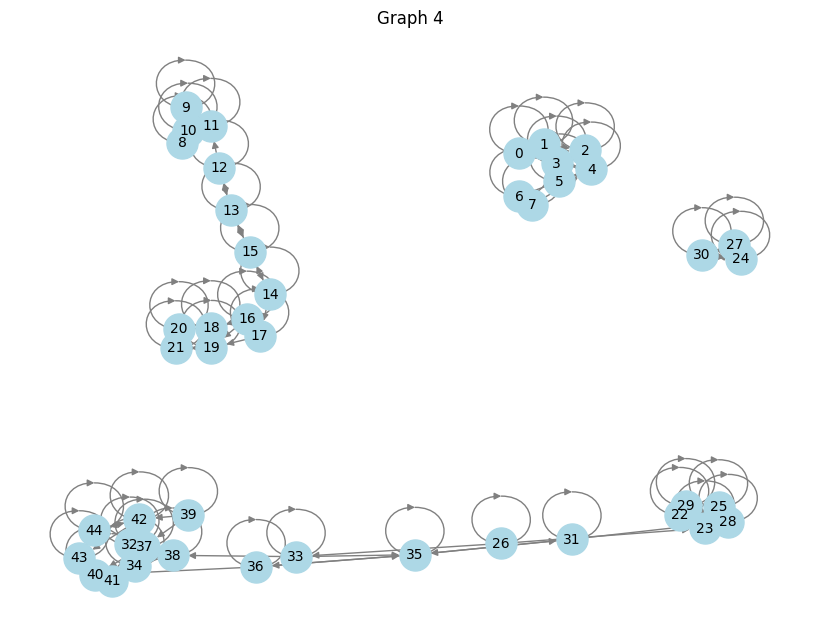

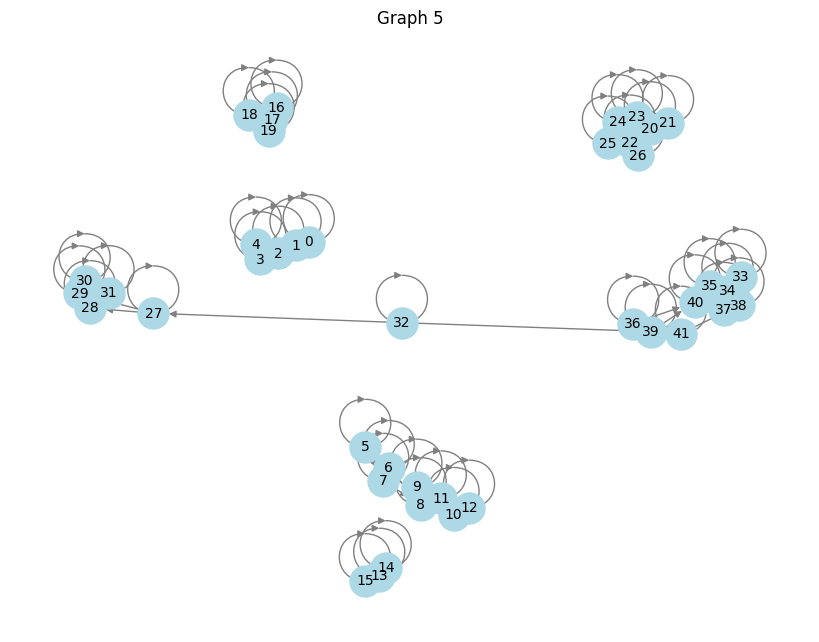

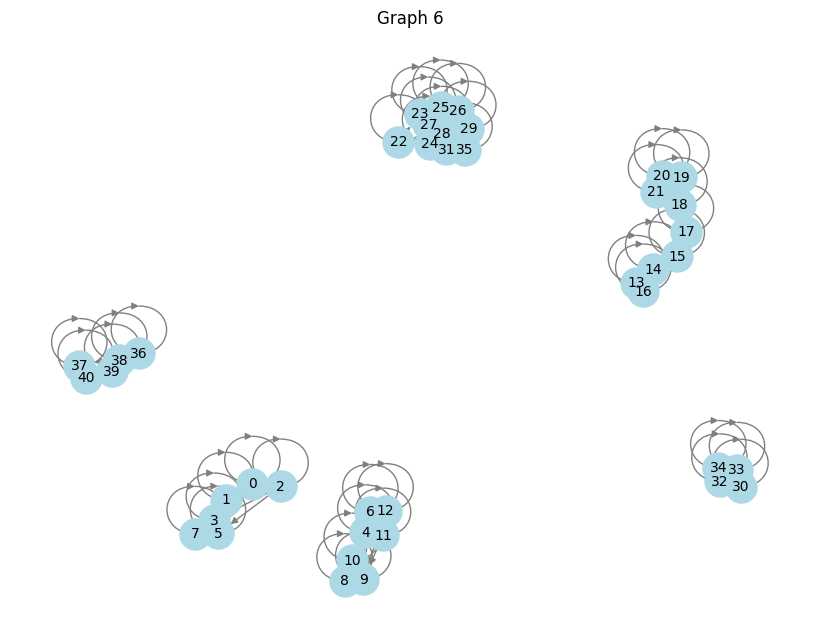

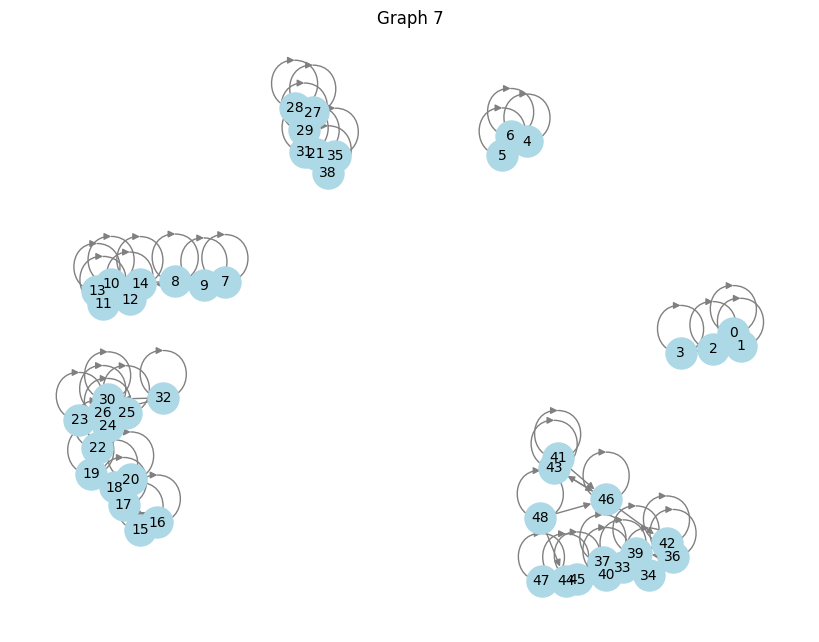

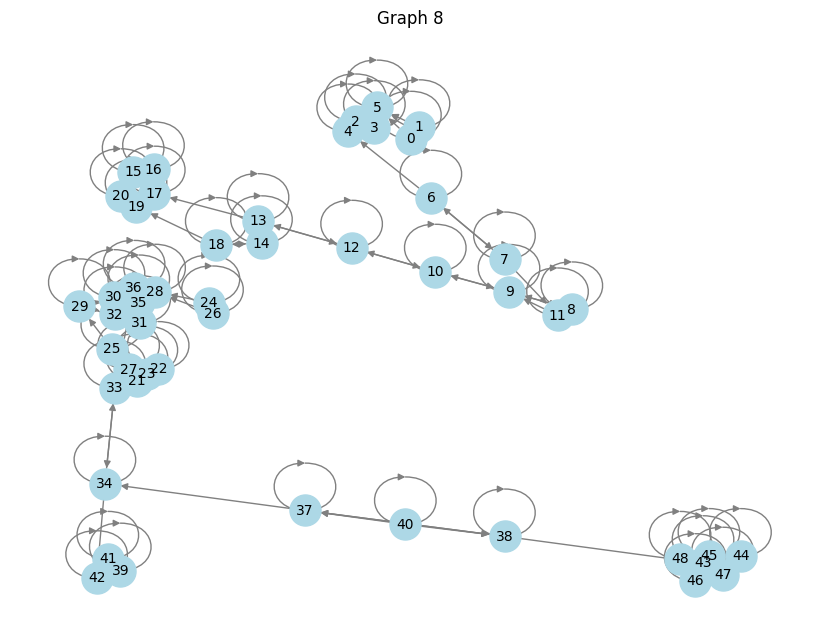

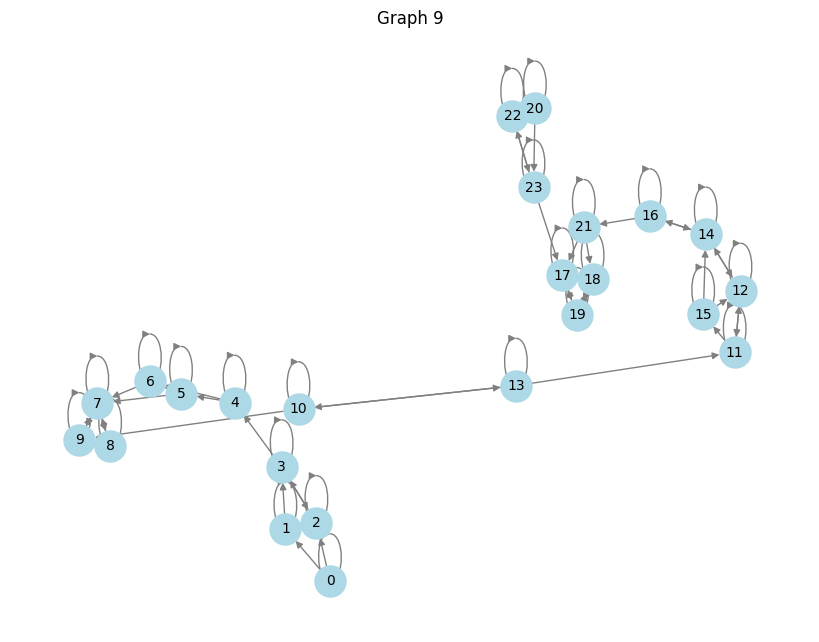

In [27]:
import networkx as nx
import matplotlib.pyplot as plt
from dgl import to_networkx

for i in range(10):  # Adjust range as needed
    G_dgl = graphs[i]
    
    # Convert DGL graph to NetworkX graph
    G_nx = to_networkx(G_dgl)
    
    # Plot using NetworkX
    plt.figure(figsize=(8, 6))
    nx.draw(G_nx, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10)
    plt.title(f"Graph {i}")
    plt.show()


In [28]:
for i in range(5):  # Adjust range as needed
    print(f"Graph {i} type: {type(graphs[i])}")


Graph 0 type: <class 'dgl.heterograph.DGLGraph'>
Graph 1 type: <class 'dgl.heterograph.DGLGraph'>
Graph 2 type: <class 'dgl.heterograph.DGLGraph'>
Graph 3 type: <class 'dgl.heterograph.DGLGraph'>
Graph 4 type: <class 'dgl.heterograph.DGLGraph'>


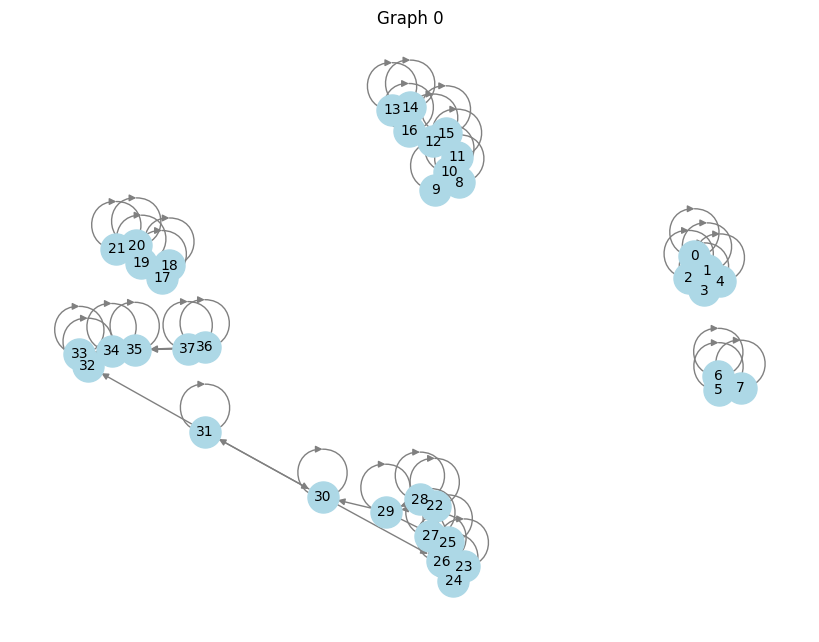

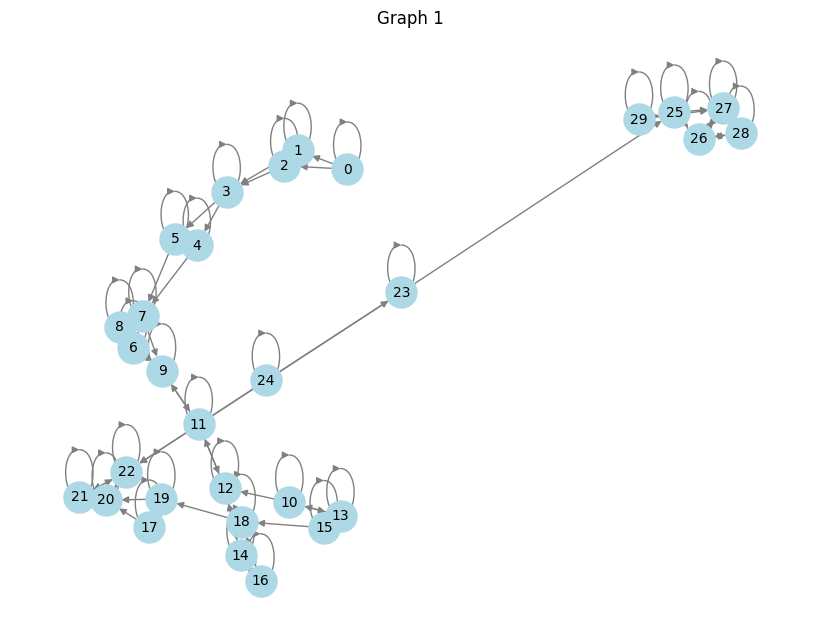

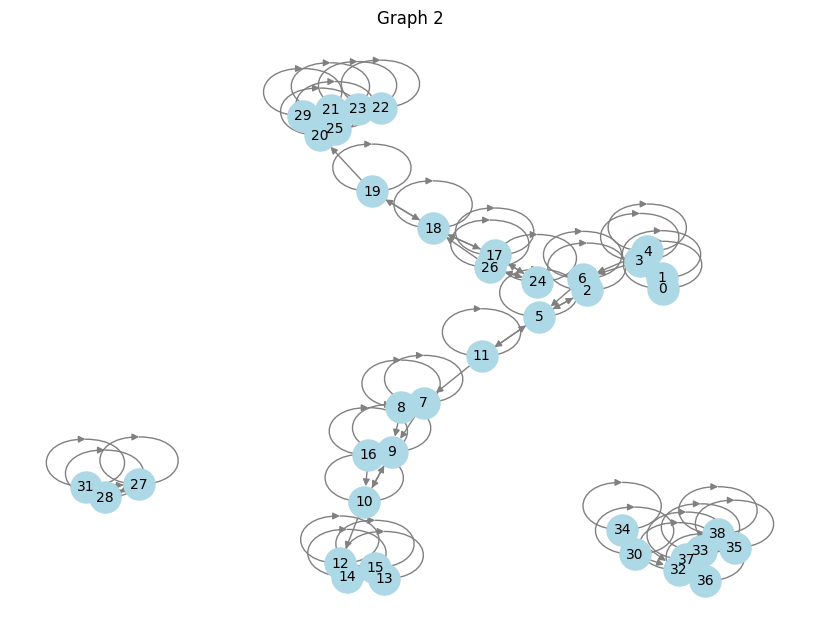

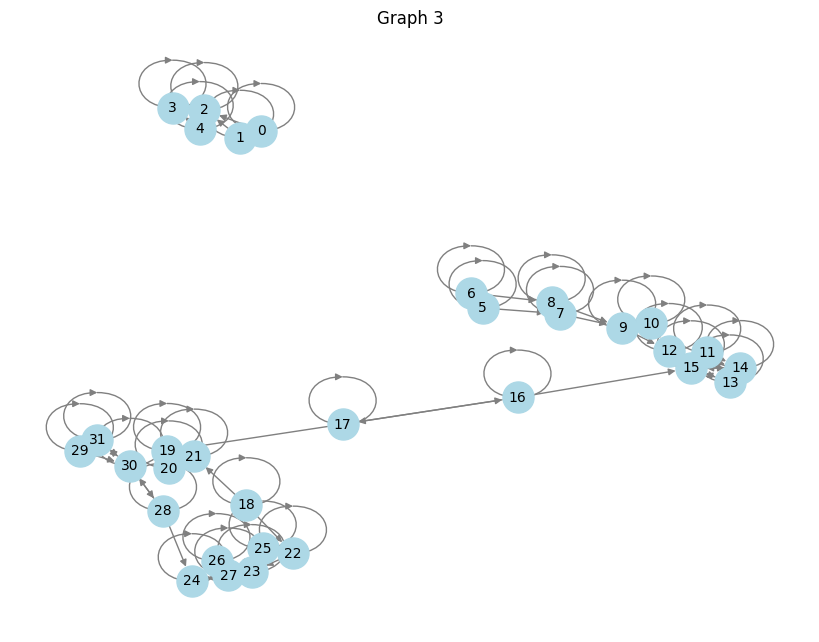

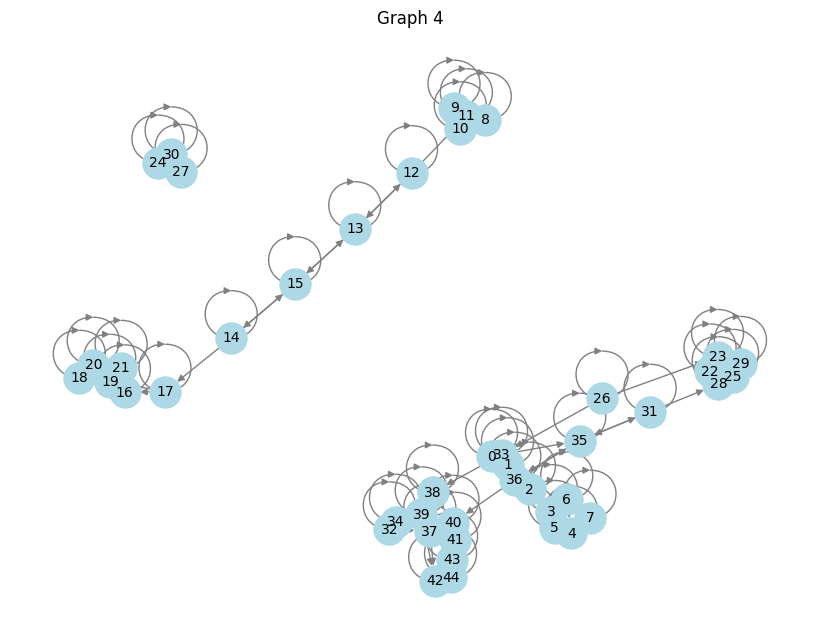

In [30]:
for i in range(5):  # Adjust range as needed
    G_dgl = graphs[i]
    
    # Convert DGL graph to NetworkX graph
    G_nx = to_networkx(G_dgl)
    
    # Plot using NetworkX
    plt.figure(figsize=(8, 6))
    nx.draw(G_nx, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10)
    plt.title(f"Graph {i}")
    plt.show()


In [31]:
edge_types = G_dgl.etypes  # List all edge types
print(f"Graph edge types: {edge_types}")


Graph edge types: ['_E']


In [32]:
print(f"Graph {i}:")
print(f"Nodes: {G_dgl.nodes()}")
print(f"Edges: {G_dgl.edges()}")
print(f"Edge types: {G_dgl.etypes}")


Graph 4:
Nodes: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44])
Edges: (tensor([ 0,  0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  5,
         6,  6,  6,  7,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10, 10, 11, 11, 11,
        12, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 15, 16, 16, 16, 17, 17, 17,
        18, 18, 18, 19, 19, 19, 20, 20, 20, 21, 21, 21, 22, 22, 22, 23, 23, 23,
        24, 24, 24, 25, 25, 25, 26, 26, 26, 27, 27, 27, 28, 28, 28, 29, 29, 29,
        30, 30, 30, 31, 31, 31, 32, 32, 32, 33, 33, 33, 34, 34, 34, 35, 35, 35,
        36, 36, 36, 37, 37, 37, 38, 38, 38, 39, 39, 39, 40, 40, 40, 41, 41, 41,
        42, 42, 42, 43, 43, 43, 44, 44, 44]), tensor([ 0,  1,  2,  1,  2,  3,  2,  3,  4,  3,  2,  4,  4,  5,  3,  5,  4,  3,
         6,  7,  4,  7,  6,  4,  8, 10, 11,  9, 11, 10, 10, 11,  9, 11, 10,  9,
     


Processing Graph 0...
  Nodes: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37])
  Edges: (tensor([ 0,  0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  5,
         6,  6,  6,  7,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10, 10, 11, 11, 11,
        12, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 15, 16, 16, 16, 17, 17, 17,
        18, 18, 18, 19, 19, 19, 20, 20, 20, 21, 21, 21, 22, 22, 22, 23, 23, 23,
        24, 24, 24, 25, 25, 25, 26, 26, 26, 27, 27, 27, 28, 28, 28, 29, 29, 29,
        30, 30, 30, 31, 31, 31, 32, 32, 32, 33, 33, 33, 34, 34, 34, 35, 35, 35,
        36, 36, 36, 37, 37, 37]), tensor([ 0,  1,  2,  1,  2,  3,  2,  1,  3,  3,  4,  2,  4,  3,  2,  5,  6,  7,
         6,  5,  7,  7,  6,  5,  8, 10, 11,  9, 10,  8, 10, 11,  8, 11, 10, 12,
        12, 15, 16, 13, 14, 16, 14, 16, 13, 15, 12, 16, 16, 14, 13, 17, 19, 18,
        18, 17, 19, 19, 17,

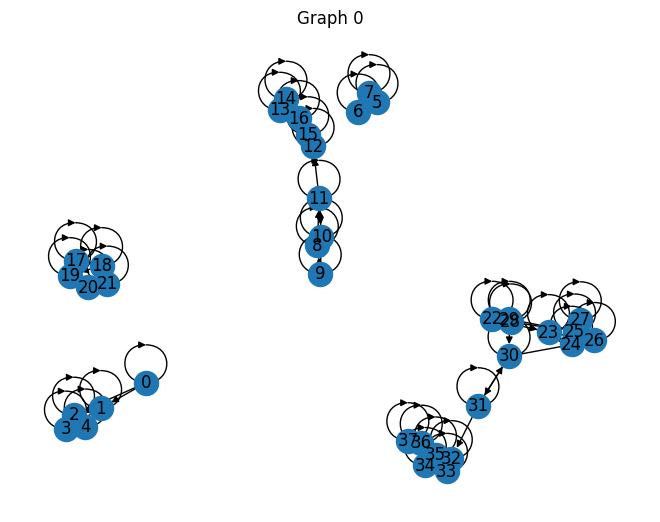

  Visualizing edge type: _E


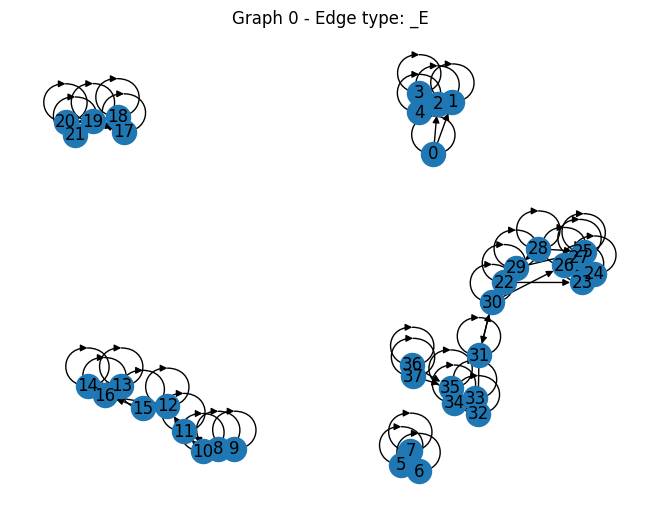


Processing Graph 1...
  Nodes: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])
  Edges: (tensor([ 0,  0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  5,
         6,  6,  6,  7,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10, 10, 11, 11, 11,
        12, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 15, 16, 16, 16, 17, 17, 17,
        18, 18, 18, 19, 19, 19, 20, 20, 20, 21, 21, 21, 22, 22, 22, 23, 23, 23,
        24, 24, 24, 25, 25, 25, 26, 26, 26, 27, 27, 27, 28, 28, 28, 29, 29, 29]), tensor([ 0,  1,  2,  1,  2,  3,  2,  1,  3,  3,  4,  5,  4,  5,  7,  5,  4,  7,
         6,  9,  7,  7,  8,  9,  8,  9,  7,  9,  8, 11, 10, 13, 12, 11, 12,  9,
        12, 11, 14, 13, 15, 10, 14, 16, 12, 15, 13, 18, 16, 14, 18, 17, 19, 20,
        18, 19, 16, 19, 17, 20, 20, 21, 22, 21, 20, 22, 22, 21, 20, 23, 22, 25,
        24, 22, 23, 25, 26, 27, 26, 27, 28, 27, 26, 28, 28, 27, 26, 29, 25, 27]))
  Edge types: ['_

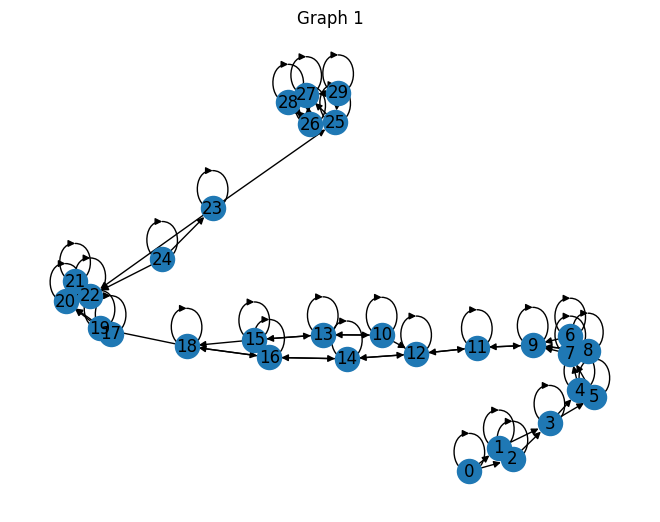

  Visualizing edge type: _E


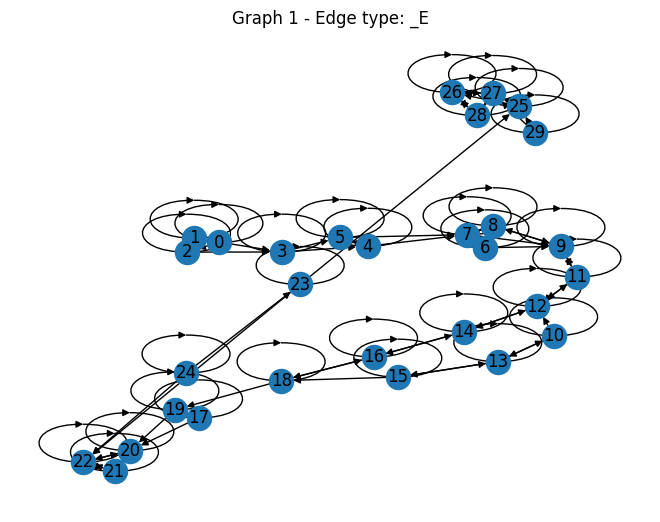


Processing Graph 2...
  Nodes: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38])
  Edges: (tensor([ 0,  0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  5,
         6,  6,  6,  7,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10, 10, 11, 11, 11,
        12, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 15, 16, 16, 16, 17, 17, 17,
        18, 18, 18, 19, 19, 19, 20, 20, 20, 21, 21, 21, 22, 22, 22, 23, 23, 23,
        24, 24, 24, 25, 25, 25, 26, 26, 26, 27, 27, 27, 28, 28, 28, 29, 29, 29,
        30, 30, 30, 31, 31, 31, 32, 32, 32, 33, 33, 33, 34, 34, 34, 35, 35, 35,
        36, 36, 36, 37, 37, 37, 38, 38, 38]), tensor([ 0,  1,  3,  1,  3,  0,  2,  6,  5,  3,  4,  6,  4,  3,  6,  5, 11,  2,
         6,  2,  5,  7,  8,  9,  8,  7,  9,  9, 10, 16, 10,  9, 12, 11,  5,  7,
        12, 13, 14, 13, 14, 15, 14, 15, 13, 15, 14, 13, 16,  9, 10, 17, 18, 24,
        18,

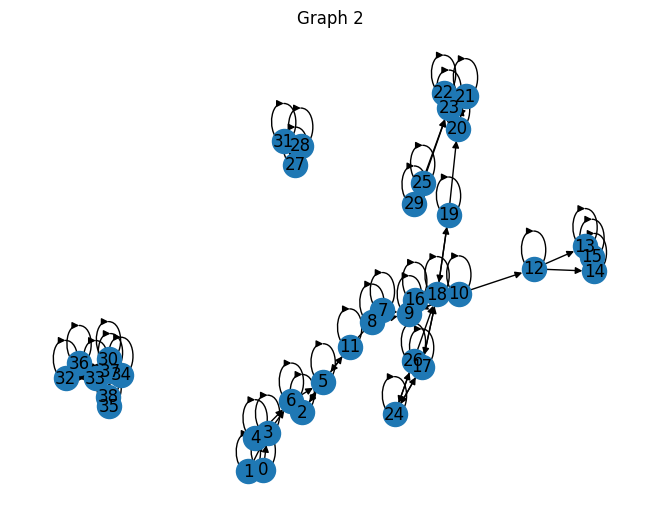

  Visualizing edge type: _E


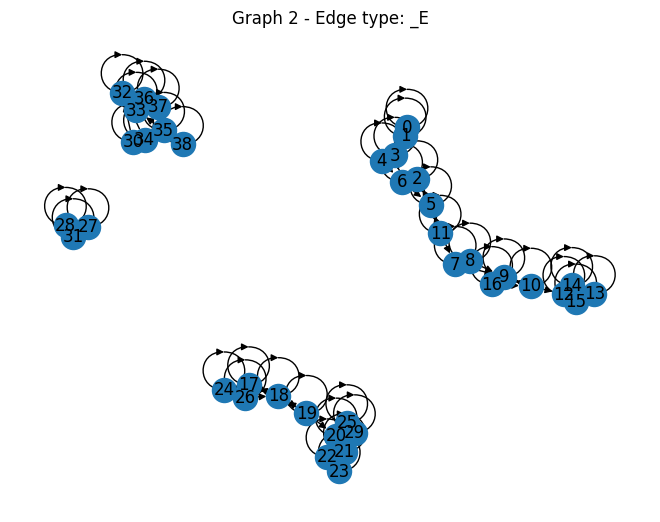


Processing Graph 3...
  Nodes: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])
  Edges: (tensor([ 0,  0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  5,
         6,  6,  6,  7,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10, 10, 11, 11, 11,
        12, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 15, 16, 16, 16, 17, 17, 17,
        18, 18, 18, 19, 19, 19, 20, 20, 20, 21, 21, 21, 22, 22, 22, 23, 23, 23,
        24, 24, 24, 25, 25, 25, 26, 26, 26, 27, 27, 27, 28, 28, 28, 29, 29, 29,
        30, 30, 30, 31, 31, 31]), tensor([ 0,  1,  2,  1,  0,  2,  2,  4,  3,  3,  4,  2,  4,  3,  2,  5,  6,  7,
         6,  5,  8,  7,  8,  9,  8,  7,  9,  9, 10, 12, 10,  9, 12, 11, 13, 14,
        12, 14, 15, 13, 15, 14, 14, 15, 13, 15, 14, 13, 16, 17, 15, 17, 16, 19,
        18, 21, 22, 19, 21, 20, 20, 19, 21, 21, 19, 20, 22, 25, 23, 23, 26, 27,
        24, 27, 26, 25, 27, 22, 26, 23, 27, 27, 24, 25, 28,

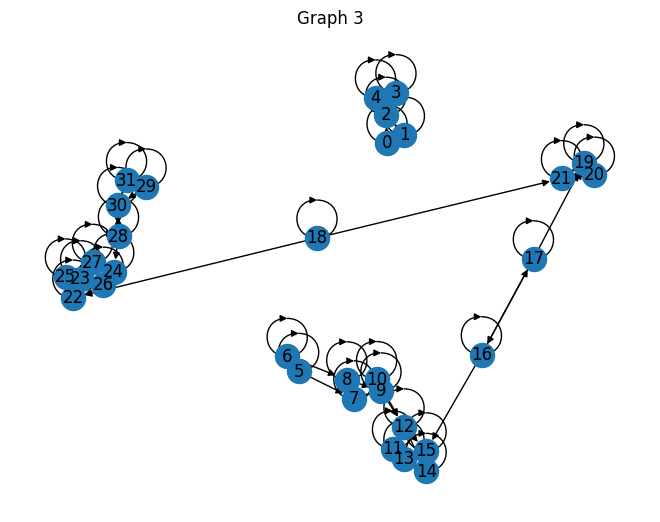

  Visualizing edge type: _E


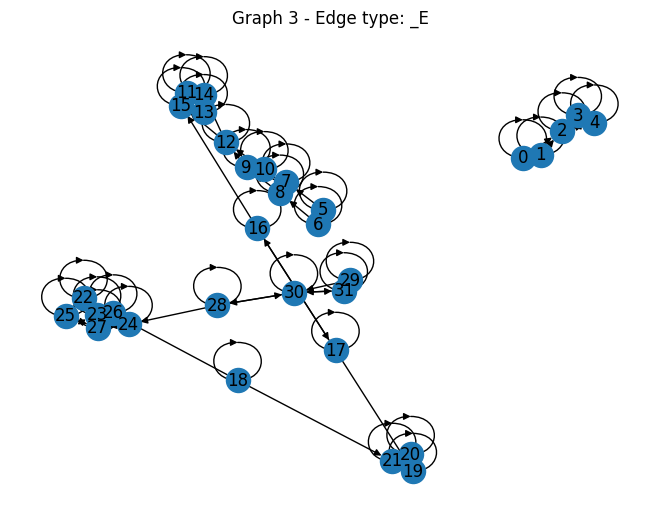


Processing Graph 4...
  Nodes: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44])
  Edges: (tensor([ 0,  0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  5,
         6,  6,  6,  7,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10, 10, 11, 11, 11,
        12, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 15, 16, 16, 16, 17, 17, 17,
        18, 18, 18, 19, 19, 19, 20, 20, 20, 21, 21, 21, 22, 22, 22, 23, 23, 23,
        24, 24, 24, 25, 25, 25, 26, 26, 26, 27, 27, 27, 28, 28, 28, 29, 29, 29,
        30, 30, 30, 31, 31, 31, 32, 32, 32, 33, 33, 33, 34, 34, 34, 35, 35, 35,
        36, 36, 36, 37, 37, 37, 38, 38, 38, 39, 39, 39, 40, 40, 40, 41, 41, 41,
        42, 42, 42, 43, 43, 43, 44, 44, 44]), tensor([ 0,  1,  2,  1,  2,  3,  2,  3,  4,  3,  2,  4,  4,  5,  3,  5,  4,  3,
         6,  7,  4,  7,  6,  4,  8, 10, 11,  9, 11, 10, 10, 11,  9,

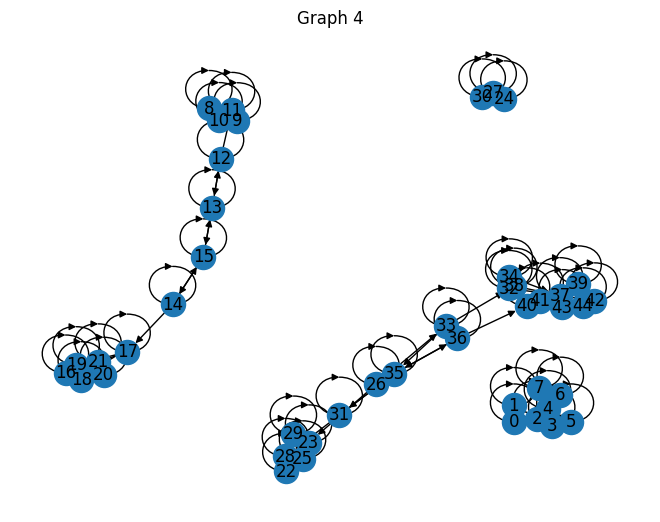

  Visualizing edge type: _E


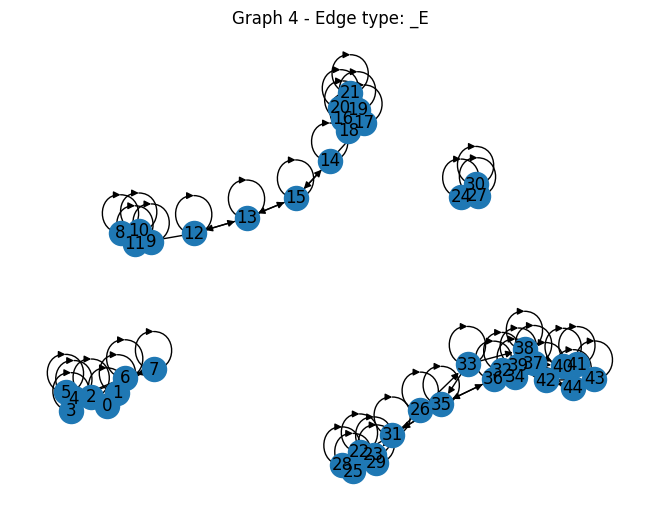

In [33]:
# Process all graphs in a loop
def process_graphs_in_loop(graphs, num_graphs=5):
    for i in range(min(num_graphs, len(graphs))):  # Process only the specified number of graphs
        print(f"\nProcessing Graph {i}...")

        try:
            graph = graphs[i]
            
            # Step 1: Inspect the graph
            print(f"  Nodes: {graph.nodes()}")
            print(f"  Edges: {graph.edges()}")
            if hasattr(graph, 'etypes'):
                print(f"  Edge types: {graph.etypes}")
            else:
                print("  No edge types available.")
            
            # Step 2: Visualize the graph
            if isinstance(graph, dgl.DGLGraph):  # Check if it's a DGL graph
                try:
                    G_nx = graph.to_networkx()  # Convert to NetworkX
                    nx.draw(G_nx, with_labels=True)
                    plt.title(f"Graph {i}")
                    plt.show()
                except Exception as viz_error:
                    print(f"  Visualization error for Graph {i}: {viz_error}")
            else:
                print(f"  Graph {i} is not a DGL graph, skipping visualization.")

            # Step 3: Handle edge types (if applicable)
            if hasattr(graph, 'etypes'):
                for edge_type in graph.etypes:
                    try:
                        print(f"  Visualizing edge type: {edge_type}")
                        subgraph = graph.edge_type_subgraph([edge_type])
                        G_nx = subgraph.to_networkx()
                        nx.draw(G_nx, with_labels=True)
                        plt.title(f"Graph {i} - Edge type: {edge_type}")
                        plt.show()
                    except Exception as edge_error:
                        print(f"  Error visualizing edge type {edge_type} for Graph {i}: {edge_error}")

        except Exception as e:
            print(f"  Error processing Graph {i}: {e}")



# Process the graphs
process_graphs_in_loop(graphs, num_graphs=5)


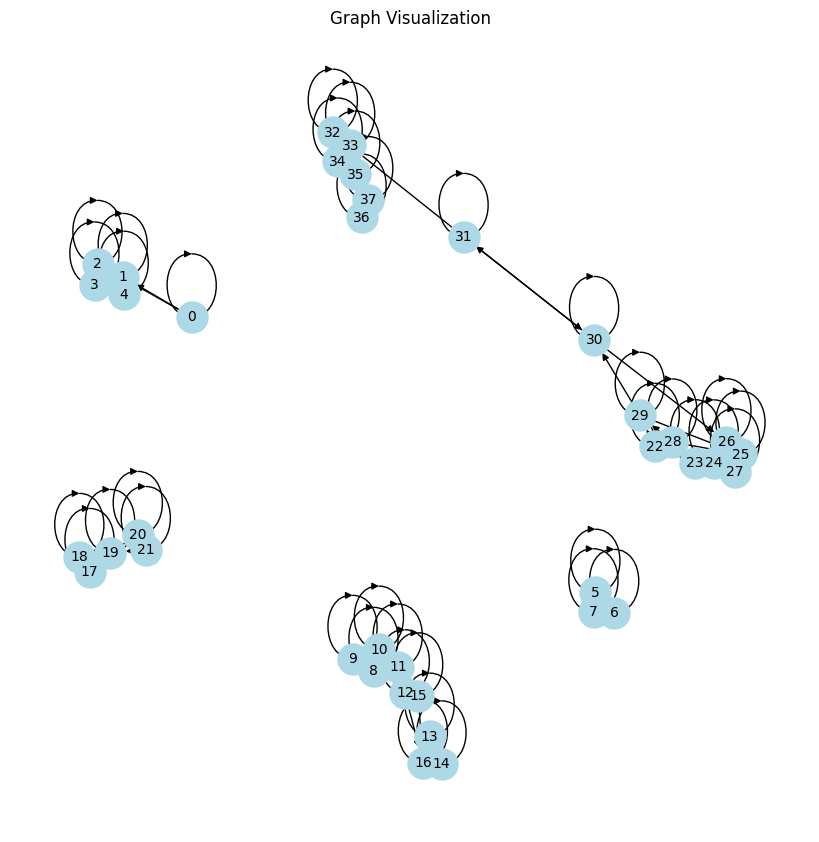

In [34]:
# Select the first graph
g = graphs[0]

# Convert to NetworkX graph
nx_graph = g.to_networkx()

# Visualize using NetworkX
plt.figure(figsize=(8, 8))
nx.draw(nx_graph, with_labels=True, node_color="lightblue", node_size=500, font_size=10)
plt.title("Graph Visualization")
plt.show()

In [35]:
# Step 6: Validation - Check feature statistics
print("Particle Features Statistics:")
print(particle_features.describe())

print("Jet Features Statistics:")
print(jet_features.describe())

Particle Features Statistics:
            part_px       part_py       part_pz   part_energy     part_deta  \
count  3.930539e+06  3.930539e+06  3.930539e+06  3.930539e+06  3.930539e+06   
mean   2.955804e-03 -7.955700e-04 -4.394205e-02  2.309210e+01 -1.064381e-03   
std    2.577370e+01  2.569026e+01  4.237366e+01  5.085870e+01  2.143027e-01   
min   -7.386595e+02 -8.513648e+02 -2.112574e+03  2.782737e-01 -3.235633e+00   
25%   -3.284608e+00 -3.238491e+00 -4.139557e+00  3.713851e+00 -1.049897e-01   
50%    1.062604e-03  5.421870e-03  1.098692e-02  8.202088e+00 -4.993960e-03   
75%    3.277013e+00  3.264697e+00  4.145223e+00  2.098487e+01  9.364326e-02   
max    7.753411e+02  8.129856e+02  1.879936e+03  2.193275e+03  2.487157e+00   

          part_dphi    part_d0val    part_d0err    part_dzval    part_dzerr  \
count  3.930539e+06  3.930539e+06  3.930539e+06  3.930539e+06  3.930539e+06   
mean   1.408771e-05  5.506787e-04  1.472127e-02  4.630799e-03  3.803251e-02   
std    2.047604e-01  

In [36]:
# Check for missing values
print("Missing Values in Particle Features:")
print(particle_features.isnull().sum())

print("Missing Values in Jet Features:")
print(jet_features.isnull().sum())

Missing Values in Particle Features:
part_px                 0
part_py                 0
part_pz                 0
part_energy             0
part_deta               0
part_dphi               0
part_d0val              0
part_d0err              0
part_dzval              0
part_dzerr              0
part_charge             0
part_isChargedHadron    0
part_isNeutralHadron    0
part_isPhoton           0
part_isElectron         0
part_isMuon             0
dtype: int64
Missing Values in Jet Features:
jet_pt            0
jet_eta           0
jet_phi           0
jet_energy        0
jet_nparticles    0
jet_sdmass        0
jet_tau1          0
jet_tau2          0
jet_tau3          0
jet_tau4          0
dtype: int64


In [37]:
# Step 8: Split data into train, validation, and test
# Split the dataset into training, validation, and test sets
train_graphs, test_graphs, train_labels, test_labels = train_test_split(
    graphs, labels, test_size=0.2, random_state=42
)
val_graphs, test_graphs, val_labels, test_labels = train_test_split(
    test_graphs, test_labels, test_size=0.5, random_state=42
)

In [38]:
# Save splits for reuse
torch.save((train_graphs, train_labels), "../graphs/train_data.pt")
torch.save((val_graphs, val_labels), "../graphs/val_data.pt")
torch.save((test_graphs, test_labels), "../graphs/test_data.pt")
print("Train/Validation/Test splits saved.")

Train/Validation/Test splits saved.


In [39]:
# Step 9: Analyze graph properties
for i, g in enumerate(graphs[:5]):  # Analyze the first 5 graphs
    print(f"Graph {i}:")
    print(f"  Number of nodes: {g.num_nodes()}")
    print(f"  Number of edges: {g.num_edges()}")

Graph 0:
  Number of nodes: 38
  Number of edges: 114
Graph 1:
  Number of nodes: 30
  Number of edges: 90
Graph 2:
  Number of nodes: 39
  Number of edges: 117
Graph 3:
  Number of nodes: 32
  Number of edges: 96
Graph 4:
  Number of nodes: 45
  Number of edges: 135


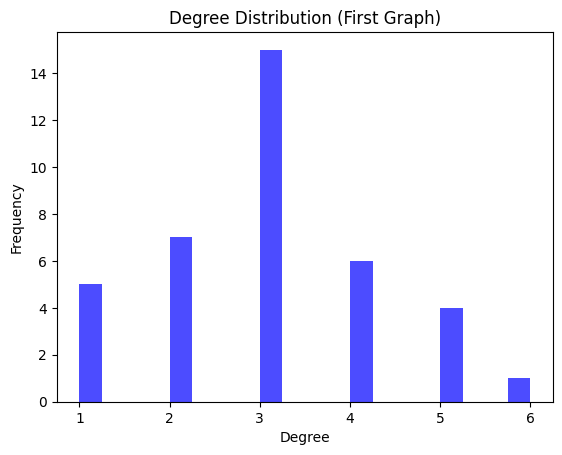

In [40]:
# Degree distribution for the first graph
g = graphs[0]
degrees = g.in_degrees().numpy()
plt.hist(degrees, bins=20, color="blue", alpha=0.7)
plt.title("Degree Distribution (First Graph)")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

In [41]:
# Step 10: Save preprocessing summary
label_distribution = Counter(labels)
summary = {
    "Total graphs": len(graphs),
    "Label distribution": dict(label_distribution),
    "Train set size": len(train_graphs),
    "Validation set size": len(val_graphs),
    "Test set size": len(test_graphs)
}

In [42]:
with open("../graphs/preprocessing_summary.json", "w") as f:
    json.dump(summary, f, indent=4)

print("Preprocessing Summary:")
print(summary)

Preprocessing Summary:
{'Total graphs': 100000, 'Label distribution': {1: 10000, 2: 10000, 3: 10000, 5: 10000, 4: 10000, 9: 10000, 8: 10000, 7: 10000, 0: 10000, 6: 10000}, 'Train set size': 80000, 'Validation set size': 10000, 'Test set size': 10000}


In [43]:
print(f"Number of graphs: {len(graphs)}")
print(graphs[0])  # Inspect the first graph

Number of graphs: 100000
Graph(num_nodes=38, num_edges=114,
      ndata_schemes={'feat': Scheme(shape=(16,), dtype=torch.float32)}
      edata_schemes={})


In [44]:
train_data = torch.load("../graphs/train_data.pt")
print(f"Train set size: {len(train_data[0])} graphs, {len(train_data[1])} labels")


/tmp/ipykernel_2539561/2509520660.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load("../graphs/train_data.pt")


Train set size: 80000 graphs, 80000 labels


In [ ]:
# part_px	part_py	part_pz	part_energy	part_deta	part_dphi	part_d0val	part_d0err	part_dzval	part_dzerr	part_charge	part_isChargedHadron	part_isNeutralHadron	part_isPhoton	part_isElectron	part_isMuon	label_QCD	label_Hbb	label_Hcc	label_Hgg	label_H4q	label_Hqql	label_Zqq	label_Wqq	label_Tbqq	label_Tbl	jet_pt	jet_eta	jet_phi	jet_energy	jet_nparticles	jet_sdmass	jet_tau1	jet_tau2	jet_tau3	jet_tau4	aux_genpart_eta	aux_genpart_phi	aux_genpart_pid	aux_genpart_pt	aux_truth_match
